In [1]:
!pip install numpy
!pip install matplotlib
!pip install pandas


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Load CSV

- Load the CSV file containing the scores data
- Filter the data to include only the "Foundations of ML" course

In [3]:
df = pd.read_csv('data/raw/scores.csv')
df = df[df['CourseName'] == 'Foundations of ML']
df.head()

,MemberName,EducationLevel,Attendance,TotalHours,AssignmentsCompleted,HackathonParticipation,GitHubScore,PeerReviewScore,CourseName,CapstoneScore
0,Theekshana Rathnayake,3,79.9,43.7,2,0,62.8,5.0,Foundations of ML,45.3
1,Mayura Sandakalum Sellapperuma,2,76.8,95.6,6,0,87.4,2.7,Foundations of ML,78.8
2,Amila Narangoda,3,96.6,75.9,8,0,98.4,2.8,Foundations of ML,65.4
4,Tharusha Vihanga,2,83.2,24.0,6,0,41.8,4.2,Foundations of ML,40.1
7,Chamath Perera,3,86.5,88.0,5,0,23.9,1.3,Foundations of ML,68.2


### Load features and scale

In [4]:
def min_max_scale(X):
    X_min = np.min(X, axis=0)
    X_max = np.max(X, axis=0)
    X_scaled = (X - X_min) / (X_max - X_min)
    return X_scaled, X_min, X_max

In [5]:
X_attendance = df['Attendance'].values
X_attendance_scaled, X_attendance_min, X_attendance_max = min_max_scale(X_attendance.reshape(-1, 1))

X_study_hours = df['TotalHours'].values
X_study_hours_scaled, X_study_hours_min, X_study_hours_max = min_max_scale(X_study_hours.reshape(-1, 1))

X_assignments = df['AssignmentsCompleted'].values
X_assignments_scaled, X_assignments_min, X_assignments_max = min_max_scale(X_assignments.reshape(-1, 1))

X_quiz = df['PeerReviewScore'].values
X_quiz_scaled, X_quiz_min, X_quiz_max = min_max_scale(X_quiz.reshape(-1, 1))

X_participation = df['HackathonParticipation'].values
X_participation_scaled, X_participation_min, X_participation_max = min_max_scale(X_participation.reshape(-1, 1))

In [6]:
X = np.column_stack([
    np.ones(len(df)),
    X_attendance_scaled.flatten(),
    X_study_hours_scaled.flatten(),
    X_assignments_scaled.flatten(),
    X_quiz_scaled.flatten(),
    X_participation_scaled.flatten()
])

y = (df['CapstoneScore'] >= 75).astype(int)

### Util functions

- format_value_for_printing: Format values for better readability

In [7]:
def format_value_for_printing(value):
    if np.isinf(value):
        return "∞"
    elif np.isnan(value):
        return "NaN"
    else:
        return f"{value:.4f}"

### Analyzing Functions

In [8]:
# Constants
CONVERGENCE_THRESHOLD = 1e-6

In [9]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_logistic_cost(X, y, theta):
    m = len(y)
    z = X @ theta
    h = sigmoid(z)

    epsilon = 1e-15
    h = np.clip(h, epsilon, 1 - epsilon)
    cost = -(1/m) * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))

    return cost

def compute_logistic_gradients(X, y, theta):
    m = len(y)
    z = X @ theta
    h = sigmoid(z)

    gradients = (1/m) * X.T @ (h - y)
    return gradients

def logistic_gradient_descent(X, y, learning_rate):
    n_features = X.shape[1]
    theta = np.random.normal(0, 0.01, n_features)
    n_iterations = 100000
    cost_history = []
    converged = False

    for i in range(n_iterations):
        cost = compute_logistic_cost(X, y, theta)
        cost_history.append(cost)

        gradients = compute_logistic_gradients(X, y, theta)

        theta = theta - learning_rate * gradients

        # Check for convergence
        if i > 10:
            change = abs(cost_history[-1] - cost_history[-10])
            if change < CONVERGENCE_THRESHOLD:
                print(f"Converged at {i}")
                converged = True
                break

        # Check for non convergence
        if np.isinf(cost):
            print("Cost diverged. Exiting...")
            break

    return theta, cost_history, converged

def predict_proba(X, theta):
    z = X @ theta
    return sigmoid(z)

def predict_class(X, theta, threshold=0.5):
    probabilities = predict_proba(X, theta)
    return (probabilities >= threshold).astype(int)

### Prediction

In [10]:
theta, costs, converged = logistic_gradient_descent(X, y, learning_rate=0.1)

y_prob = predict_proba(X, theta)
y_pred = predict_class(X, theta, threshold=0.5)

Converged at 83293


### Visualize results

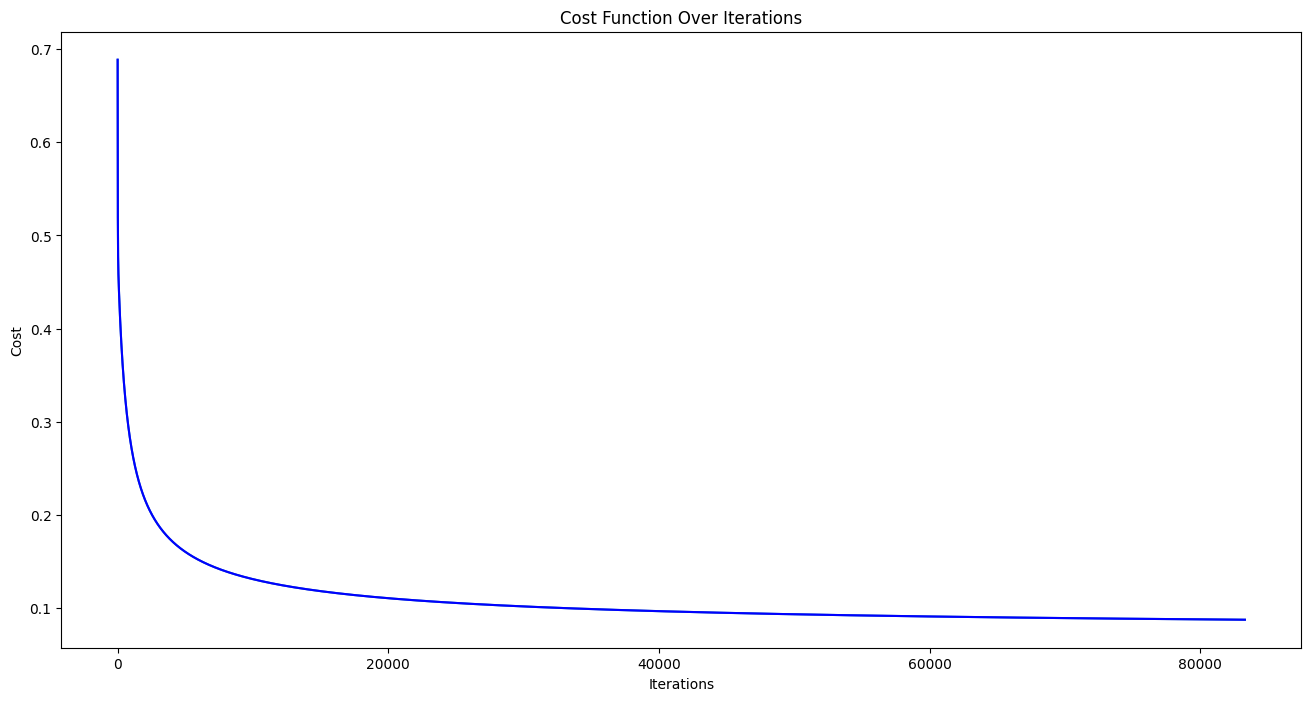

In [11]:
plt.figure(figsize=(16, 8))
plt.plot(costs)
plt.plot(costs, label='Cost Function', color='blue')
plt.title('Cost Function Over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

### Evaluation metrics

In [12]:
def calculate_evaluation_metrics(y_true, y_pred):
    accuracy = np.mean(y_true == y_pred)
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return accuracy, tp, fp, tn, fn, precision, recall, f1

In [13]:
print("\n" + "="*70)
print("EVALUATION SUMMARY")
print("="*70)
print(f"{'Threshold':<15} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1':<12}")
print("-"*70)

accuracy, tp, fp, tn, fn, precision, recall, f1 = calculate_evaluation_metrics(y, y_pred)
print(f"{'0.5':<15} {format_value_for_printing(accuracy):<12} {format_value_for_printing(precision):<12} {format_value_for_printing(recall):<12} {format_value_for_printing(f1):<12}")


EVALUATION SUMMARY
Threshold       Accuracy     Precision    Recall       F1          
----------------------------------------------------------------------
0.5             0.9583       0.8462       0.9167       0.8800      
